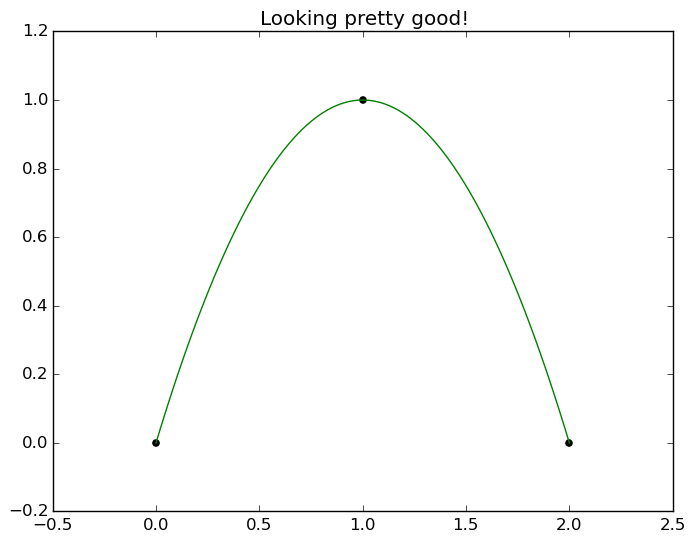

In [2]:
###### Let's begin with a simple example, with no jerk optimization: ######
# Easiest case: pointwise constraints:
xpts = [0,1,2];
ypts = [0,1,0];

# Let's fit a quadratic:
N=3;
x_coeff = zeros(3);
y_coeff = zeros(3);

# Assume the time vector:
T = [0,1,2];

# Form the constraints:
A = [1 T[1] T[1]^2;
     1 T[2] T[2]^2;
     1 T[3] T[3]^2];

# Now we solve the equation A*coeff = constr 
x_coeff = A\xpts;
y_coeff = A\ypts;


# Let's plot the result:
tvals= linspace(0,2,100);
xpoly = zeros(size(tvals,1))
ypoly = zeros(size(tvals,1))

t_ind = 0;
for t in tvals
    t_ind+=1;
    t_vec = [1;t;t^2];
    xpoly[t_ind] = (x_coeff'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly[t_ind] = (y_coeff'*t_vec)[1];   # we access the first element so that the type is Float64
end

using PyPlot;
figure(1); clf();
scatter(xpts,ypts,color=:black)
plot(xpoly,ypoly,color=:green)
title("Looking pretty good!");


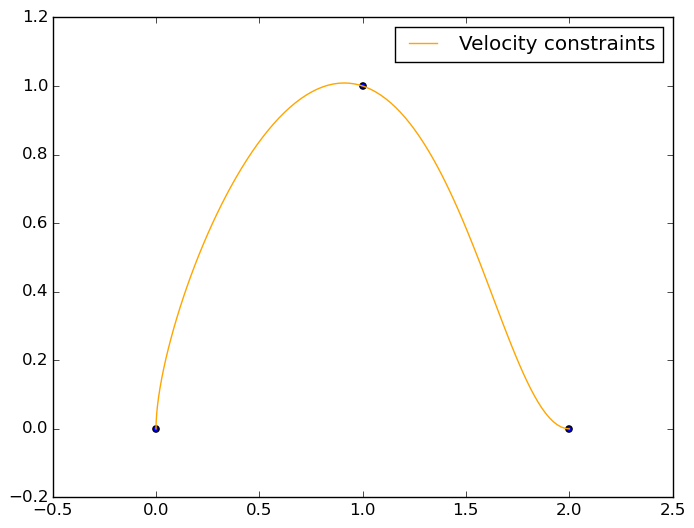

In [5]:

### Now let's add derivative constraints:
vx = [0,1]; # Correspond to initial and final times
vy = [1,0];

# We need to be less lazy about computing A now. This is a function which returns a row vector corresponding to a constraint of given order at the given time.
function constr_order( order, time, degree)
    if(order==0) 
        row_vec = ones(1,degree); 
        for n=2:degree
            row_vec[1,n] = time^(n-1);
        end
        return row_vec;
    end
    row_vec = zeros(1,degree);
    for n = order:degree-1
        coeff = 1; 
        for k=1:order
            coeff = coeff*(n+1-k)
        end

        row_vec[1,n+1] = coeff * (time^(n-order))
    end
    return row_vec;
end

# We need a new polynomial with 3+2 degree:
N = 5;
T = [0,1,2];
xpts = [0,1,2];
ypts = [0,1,0];

# Form the constraints matrix:
A = [constr_order(0,T[1],N);    # order needs to match up with the B vector
     constr_order(0,T[2],N);
     constr_order(0,T[3],N);
     constr_order(1,T[1],N);
     constr_order(1,T[3],N)];

# Form the vector of constraint values:
x_B = [xpts; vx];
y_B = [ypts; vy];

# Solve the system:
x_coeff = A\x_B;
y_coeff = A\y_B;

# Plot the result:
t_ind = 0;
for t in tvals
    t_ind+=1;
    t_vec = [1;t;t^2;t^3;t^4];
    xpoly[t_ind] = (x_coeff'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly[t_ind] = (y_coeff'*t_vec)[1];   # we access the first element so that the type is Float64
end
scatter(xpts,ypts)
plot(xpoly,ypoly,color=:orange);
legend(["Velocity constraints"]);


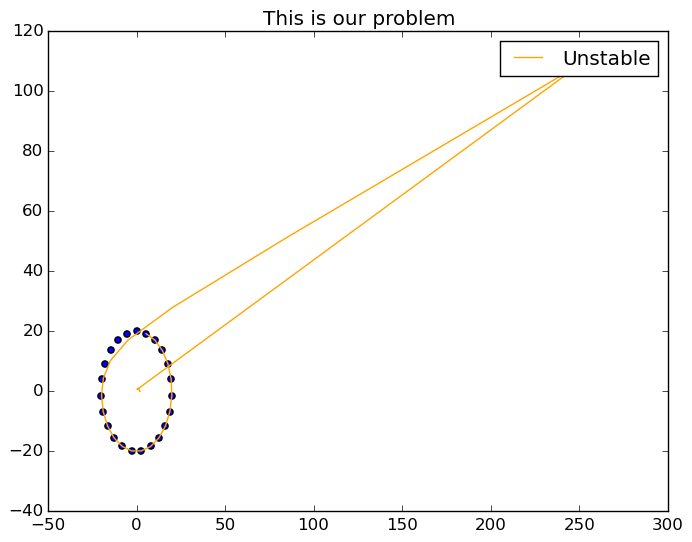

In [6]:
## Just for kicks, let's consider an example that goes very badly. 
num_pts = 23;
xpts = 20*sin(2*pi/num_pts*(1:num_pts));
ypts = 20*cos(2*pi/num_pts*(1:num_pts));
times = collect(0:num_pts-1)

# Now we try to form the A matrix:
A = zeros(0,num_pts);
for n = 1:num_pts
    A = [A; constr_order(0,times[n], num_pts)];
end
x_coeff = A\xpts;
y_coeff = A\ypts;
# Plot the result:
t_ind = 0;
for t in times
    t_ind+=1;
    t_vec = ones(num_pts);
    for k=2:num_pts
       t_vec[k] = t_vec[k-1]*t;
    end
    xpoly[t_ind] = (x_coeff'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly[t_ind] = (y_coeff'*t_vec)[1];   # we access the first element so that the type is Float64
end
figure(2);clf();
scatter(xpts, ypts);
plot(xpoly,ypoly,color=:orange);
legend(["Unstable"])
title("This is our problem");


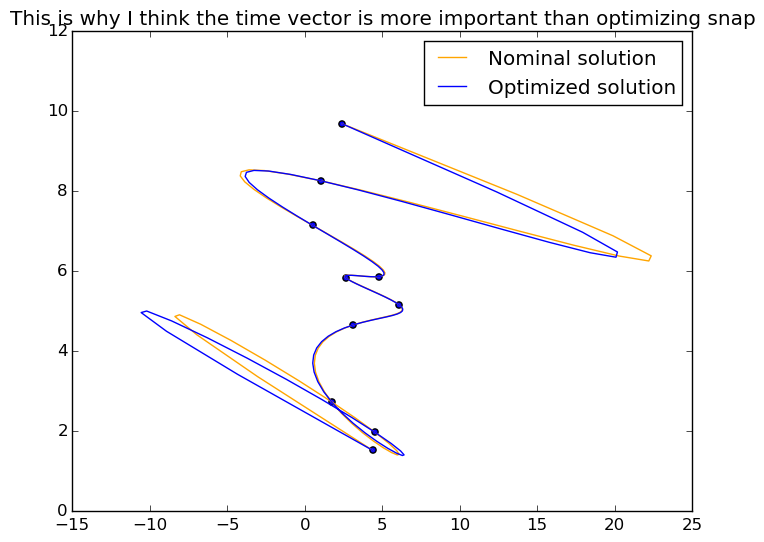

PyObject <matplotlib.text.Text object at 0x7eff1fdf9810>

In [11]:
using PyPlot;
# Let's consider a more difficult example and try optimizing the snap
num_pts = 10;
xpts = num_pts*rand(num_pts); # Only have point constraints
ypts = num_pts*rand(num_pts);
sort!(ypts);
times = collect(1:num_pts)
degree = num_pts+1 # Add a degree of freedom


# We need to be less lazy about computing A now. This is a function which returns a row vector corresponding to a constraint of given order at the given time.
function constr_order( order, time, degree)
    if(order==0) 
        row_vec = ones(1,degree); 
        for n=2:degree
            row_vec[1,n] = time^(n-1);
        end
        return row_vec;
    end
    row_vec = zeros(1,degree);
    for n = order:degree-1
        coeff = 1; 
        for k=1:order
            coeff = coeff*(n+1-k)
        end

        row_vec[1,n+1] = coeff * (time^(n-order))
    end
    return row_vec;
end
# Form the fully constrained matrix for comparison
A = zeros(0,degree-1)
for n=1:num_pts
    A = [A; constr_order(0,times[n],degree-1)];
end


A_opt = zeros(0,degree)
for n=1:num_pts
    # Position constraints only
    A_opt = [A_opt; constr_order(0,times[n],degree)];
end
# Setting our D_P derivative to the velocity at time 1 (this is an unconstrained derivative)
# Could be any deriative that is unconstrained. 
A_opt = [A_opt; constr_order(1,times[1],degree)] # Line here is the free derivative. 

# Now we add a dummy constraint?


# To optimize for snap, we weight the 5th component:
q_coeffs = zeros(degree);
q_coeffs[5] = 1.0;


function form_Q(Q_coeffs, t)
    degree = size(Q_coeffs,1)
    Q_mat = zeros(degree,degree)

    for k = 0:degree-1
        if(Q_coeffs[k+1] == 0)
            continue;
        end
        c_k = Q_coeffs[k+1];
        for i=1:degree
        # Form Q
            for l = 1:degree
                if(i >= k && l >= k)                                                   
                    c_tmp = 2*c_k
                    for m = 0:k-1 
                        c_tmp = c_tmp * (i-m)*(l-m);
                    end                                                                
                    Q_mat[i,l] += c_tmp*(t^(i+l-2*k+1))/(i+l-2*k+1)                    
                end
            # Else 0
            end
        end
    end 
    return Q_mat                                                                       
end

# Our cost function:
Q_mat = form_Q(q_coeffs, times[end])                                                   

# Compute R = A^-T Q A^-1                                                              
# This is bad practice, but easy:                                                      
Ainv = inv(A_opt);
R = (Ainv')*(Q_mat*Ainv)
#          -     R_fp           *   R_pp^-1
opt_mat = - R[1:degree-1,degree]./R[end,end];                                          
# Now we can back out the polynomials:
x_opt = A_opt\[xpts;opt_mat'*xpts];                                                    
y_opt = A_opt\[ypts;opt_mat'*ypts];                                                    
x_nom = A\xpts;                                                                        
y_nom = A\ypts;

# Plot to see how we did:
t_ind = 0;  
tvals =linspace(times[1],times[end],100);
xpoly_nom = zeros(size(tvals,1));                                                      
ypoly_nom = zeros(size(tvals,1));                                                      
xpoly_opt = zeros(size(tvals,1));                                                      
ypoly_opt = zeros(size(tvals,1));                                                      

for t in tvals
    t_ind+=1;   
    t_vec = ones(num_pts);
    for k=2:num_pts
       t_vec[k] = t_vec[k-1]*t;  
    end     
    xpoly_nom[t_ind] = (x_nom'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly_nom[t_ind] = (y_nom'*t_vec)[1];   # we access the first element so that the type is Float64
    t_vec = ones(num_pts+1);
    for k=2:num_pts+1
       t_vec[k] = t_vec[k-1]*t;                                                        
    end 
    xpoly_opt[t_ind] = (x_opt'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly_opt[t_ind] = (y_opt'*t_vec)[1];   # we access the first element so that the type is Float64
end
figure(2);clf();
scatter(xpts, ypts);
plot(xpoly_nom,ypoly_nom,color=:orange);
plot(xpoly_opt,ypoly_opt,color=:blue);
legend(["Nominal solution", "Optimized solution"])                                     
title("This is why I think the time vector is more important than optimizing snap")   

In [ ]:
Suppose we have C5 continuity - means that the first 5 derivatives of each segment match the last 5 derivatives of the previous one. 
This means each segment will have 10 continuity constraints (this includes position constraints, 0th derivative)
In addition we have 1 free derivative constraint (degree of freedom to minimize snap). Total order 11 per segment.

A1 holds the 5 derivative constraints at the beginning + free variable. 

[A1  0  0   0     [p1    [b1
  0  A2 0   0      p2  =  b2
  0  0  A3  0      p3     b3
  0  0  0  AP]     pP     bP


        Rank-1 update:        
        A ac
Aopt = ar 1
        
        

Running as a single 19 problem.
Condition number of single A: 2.9424096321338345e15
There are 3 segments for 15: 7+5+3
Condition number of joint A: 3.318296589638605e19 1.0856472585969312e19
Errors: 13.870194792747498


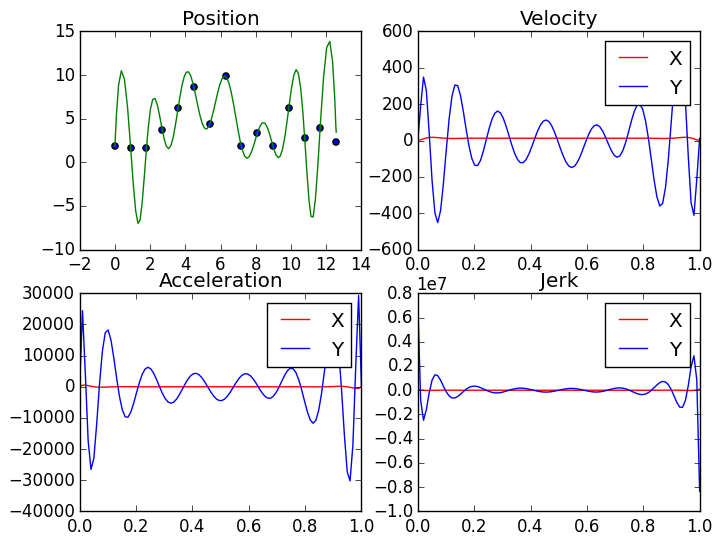

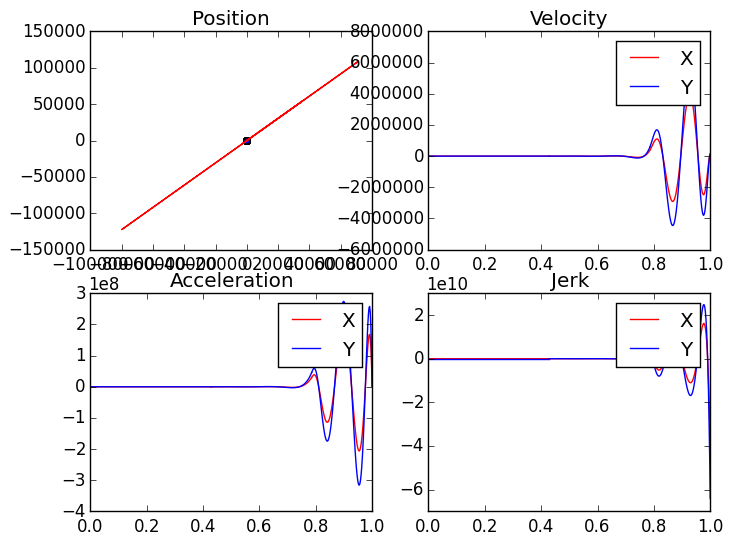

In [4]:
## poly.jl pasted here:
# This code is my work on multi-segment. This is the least tested/thought out of the bunch.

using PyPlot
function plot_poly(cx,cy,pp, T0, TF, fn)
    figure(fn);
    radius = 50;
    degree = length(cx);
    times = linspace(T0,TF,100)
    x0 = zeros(length(times))
    y0 = zeros(length(times))
    x1 = zeros(length(times))
    y1 = zeros(length(times))
    x2 = zeros(length(times))
    y2 = zeros(length(times))
    x3 = zeros(length(times))
    y3 = zeros(length(times))
    k = 0
    for t in times
        k+=1;
        for d = 1:degree
            x0[k] += cx[d] * t^(d-1)
            y0[k] += cy[d] * t^(d-1)
            if(d > 1)
                x1[k] += (d-1)*cx[d] * t^(d-2)
                y1[k] += (d-1)*cy[d] * t^(d-2)
            end
            if(d > 2)
                x2[k] += (d-1)*(d-2)*cx[d] * t^(d-3)
                y2[k] += (d-1)*(d-2)*cy[d] * t^(d-3)
            end
            if(d > 3)
                x3[k] += (d-2)*(d-1)*(d-3)*cx[d] * t^(d-4)
                y3[k] += (d-2)*(d-1)*(d-3)*cy[d] * t^(d-4)
            end
        end
    end
    
    subplot(2,2,1); title("Position");
    if(T0 == 0)
        plot(x0,y0, color=:green);
    else
        plot(x0,y0,color=:red);
    end
#    axis([-5,2*radius+5,-5,2*radius+5])
#    axis([-5,65,-5,35])
    scatter(pp[:,1], pp[:,2]);
    
    subplot(2,2,2); title("Velocity")
    plot(times, x1, color=:red)
    plot(times, y1, color=:blue)
    legend(["X", "Y"]);

    subplot(2,2,3); title("Acceleration")
    plot(times, x2, color=:red)
    plot(times, y2, color=:blue)
    legend(["X", "Y"]);

    subplot(2,2,4); title("Jerk");
    plot(times, x3, color=:red)
    plot(times, y3, color=:blue)
    legend(["X", "Y"]);
end



num_points = 15
xvals = linspace(0,4*pi,num_points);
yvals = rand(num_points)*10
points = [xvals yvals zeros(num_points,2)];
figure(42); clf(); scatter(xvals, yvals);

vinit = [1,0,0,0]; vfinal =[1,0,0,0];
ainit = [0,0,0,0]; afinal =[0,0,0,0];

times = linspace(0,1,num_points);


# Unconstrained, single polynomial fitting:

degree = num_points + 4;
println("Running as a single $degree problem.");
# Coefficients
coeff_ux = zeros(degree); # these are our coefficients
coeff_uy = zeros(degree);

# Derivative constraint values
D_ux = [points[:,1]; vinit[1]; ainit[1]; vfinal[1]; afinal[1]];
D_uy = [points[:,2]; vinit[2]; ainit[2]; vfinal[2]; afinal[2]];


# Form constraint matrix A:

constr_orders = [zeros(num_points); 1;2;1;2];
constr_times  = [times; times[1]; times[1]; times[end]; times[end]];

# For this case, A_mat is full rank.
A_mat = zeros(degree,degree);
for constr=1:degree
    order = constr_orders[constr];
    time  = constr_times[constr];

    for n = order:degree-1
        coeff = 1;
        for k=1:order
            coeff *= (n+1-k);
        end
        pwr = n-order;
        A_mat[constr,n+1] = coeff * time^pwr;
    end
end

# Invert A matrix:
A_inv = inv(A_mat);
println("Condition number of single A: ", cond(A_inv));

# Back out coefficients:
coeff_ux = A_inv*D_ux;
coeff_uy = A_inv*D_uy;


# Plot
plot_poly(coeff_ux, coeff_uy, points, times[1], times[end], 42);


# Now Split into two segments, with three orders of continuity.
# Total degree is still 'degree', but each polynomial has a strange interaction - 
num_segs = 3;
initial_cont = 2;
final_cont = 2;
cont_order = 5; # order of continuity to enforce
# shuffle points around to balance order of segments
num_pointsi = round(Int64, (num_points+initial_cont+final_cont + (num_segs-1)*cont_order)/num_segs);
num_points2 = num_pointsi-cont_order;
num_points3 = num_pointsi-2-cont_order;
num_points1 = num_points - num_points2-num_points3;
println("There are 3 segments for $num_points: $num_points1+$num_points2+$num_points3");

indep_degree1 = 2+num_points1; # This is the number of constraints 1 will be responsible for
indep_degree2 = num_points2; # 
indep_degree3 = 2+num_points3; # 2 is for final points
degree = indep_degree1+indep_degree2+indep_degree3;

tot_degree1 = indep_degree1;
tot_degree2 = indep_degree2+cont_order
tot_degree3 = indep_degree3+cont_order

# Easy mapping
coeffs_map1 = [eye(indep_degree1) zeros(indep_degree1,degree-indep_degree1)];
coeffs_map2 = [zeros(cont_order, degree); [zeros(indep_degree2,indep_degree1) eye(indep_degree2) zeros(indep_degree2, indep_degree3)]];
coeffs_map3 = [zeros(cont_order, degree); [zeros(indep_degree3, indep_degree1+indep_degree2) eye(indep_degree3)]];

# Solve system backwards:
for k=cont_order:-1:1
    coeffs_map2[k,:] = coeffs_map1[k,:];
    max_deg = max(tot_degree1-1,tot_degree2-1)
    for i=k:max_deg
        coeff = times[num_points1]^(i-(k-1));
        for m=1:(k-1)
            coeff*=(i-(m-1))/(m);
        end
        if(i < tot_degree1)
            coeffs_map2[k,:] += coeff*coeffs_map1[i+1,:];
        end
        if(i < tot_degree2)
            coeffs_map2[k,:] -= coeff*coeffs_map2[i+1,:];
        end
    end
end

# Solve system backwards:
for k=cont_order:-1:1
    coeffs_map3[k,:] = coeffs_map2[k,:];
    max_deg = max(tot_degree3-1,tot_degree2-1)
    for i=k:max_deg
        coeff = times[num_points1+num_points2]^(i-(k-1));
        for m=1:(k-1)
            coeff*=(i-(m-1))/(m);
        end
        if(i < tot_degree2)
            coeffs_map3[k,:] += coeff*coeffs_map2[i+1,:];
        end
        if(i < tot_degree3)
            coeffs_map3[k,:] -= coeff*coeffs_map3[i+1,:];
        end
    end
end

# Derivative constraint values
D_ux = [points[:,1]; vinit[1]; ainit[1]; vfinal[1]; afinal[1]];
D_uy = [points[:,2]; vinit[2]; ainit[2]; vfinal[2]; afinal[2]];

# Now compute A matrix:

constr_orders = [zeros(num_points); 1;2;1;2];
constr_times  = [times; times[1]; times[1]; times[end]; times[end]];

# For this case, A_mat is full rank.
A_mat = zeros(degree,degree);
for constr=1:degree
    order = constr_orders[constr];
    time  = constr_times[constr];
    if(time <= times[num_points1]) # This constraint belongs to the first polynomial
        deg = tot_degree1;
        coeff_mat = coeffs_map1;
    elseif(time <= times[num_points1+num_points2]) # This constraint belongs to the second polynomial:
        deg = tot_degree2;
        coeff_mat = coeffs_map2;
    else # third.
        deg = tot_degree3;
        coeff_mat = coeffs_map3;
    end
    for n = order:deg-1
        coeff = 1;
        for k=1:order
            coeff *= (n+1-k);
        end
        pwr = n-order;
        A_mat[constr,:] += coeff*(time^pwr).*coeff_mat[n+1,:];
    end
end
# Invert A matrix:
A_inv = inv(A_mat);
println("Condition number of joint A: ", cond(A_mat)," ",cond(A_inv));

Ax = A_mat\D_ux;
Ay = A_mat\D_uy;
Ax = A_inv*D_ux;
Ay = A_inv*D_uy;

println("Errors: ", maximum(A_inv*A_mat-eye(degree)))

# Back out coefficients:
coeff_ux1 = coeffs_map1*Ax;
coeff_uy1 = coeffs_map1*Ay;
coeff_ux2 = coeffs_map2*Ax;
coeff_uy2 = coeffs_map2*Ay;
coeff_ux3 = coeffs_map3*Ax;
coeff_uy3 = coeffs_map3*Ay;

# Plot
plot_poly(coeff_ux1, coeff_uy1, points, times[1], times[num_points1], 43);
plot_poly(coeff_ux2, coeff_uy2, points, times[num_points1],times[num_points1+num_points2], 43);
plot_poly(coeff_ux3, coeff_uy3, points, times[num_points1+num_points2],times[end], 43);









